In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_absolute_error, mean_squared_error



In [4]:
# -----------------------------
# 2. Load Dataset
# -----------------------------

df = pd.read_csv("superstore_data.csv")

# Convert date column
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Sort by date
df = df.sort_values('Order Date')

print("Dataset Loaded Successfully")
print(df.head())

Dataset Loaded Successfully
      Order ID Order Date         Category Sub-Category   Region  \
1146      1147 2021-01-03        Furniture       Tables  Central   
653        654 2021-01-03       Technology  Accessories     East   
56          57 2021-01-03  Office Supplies      Binders    South   
1469      1470 2021-01-03        Furniture    Bookcases     West   
1139      1140 2021-01-04        Furniture       Chairs     East   

         Ship Mode   Sales  
1146      Same Day  304.37  
653   Second Class  253.03  
56        Same Day  137.20  
1469      Same Day  119.16  
1139      Same Day  535.98  


In [5]:
# -----------------------------
# 3. Aggregate Daily Sales
# -----------------------------

daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales = daily_sales.sort_values('Order Date')

print("\nDaily Sales Aggregated")
print(daily_sales.head())



Daily Sales Aggregated
  Order Date    Sales
0 2021-01-03   813.76
1 2021-01-04  2008.76
2 2021-01-06  1352.34
3 2021-01-07   685.36
4 2021-01-08  1452.94


In [6]:
# -----------------------------
# 4. Handle Missing Dates
# -----------------------------

full_range = pd.date_range(
    start=daily_sales['Order Date'].min(),
    end=daily_sales['Order Date'].max()
)

daily_sales = daily_sales.set_index('Order Date')
daily_sales = daily_sales.reindex(full_range, fill_value=0)
daily_sales.index.name = 'Order Date'
daily_sales = daily_sales.reset_index()

print("\nMissing Dates Handled")
print(daily_sales.head())



Missing Dates Handled
  Order Date    Sales
0 2021-01-03   813.76
1 2021-01-04  2008.76
2 2021-01-05     0.00
3 2021-01-06  1352.34
4 2021-01-07   685.36


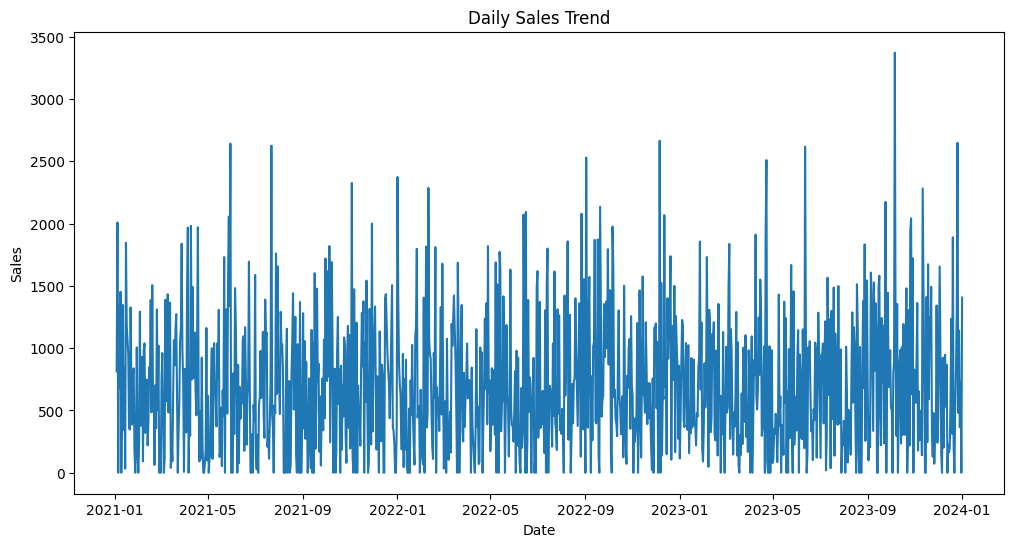

In [7]:
# -----------------------------
# 5. Exploratory Data Analysis
# -----------------------------

plt.figure(figsize=(12,6))
plt.plot(daily_sales['Order Date'], daily_sales['Sales'])
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


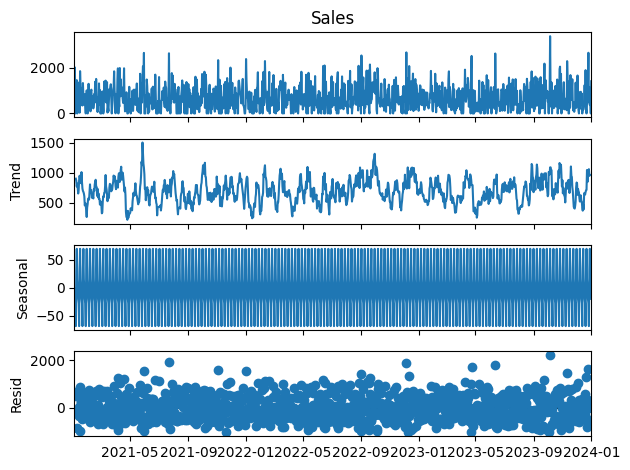

In [8]:
# -----------------------------
# 6. Time Series Decomposition
# -----------------------------

daily_sales.set_index('Order Date', inplace=True)

decomposition = seasonal_decompose(
    daily_sales['Sales'],
    model='additive',
    period=7
)

decomposition.plot()
plt.show()

In [9]:

# -----------------------------
# 7. Stationarity Test (ADF)
# -----------------------------

adf_result = adfuller(daily_sales['Sales'])

print("\nADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])




ADF Statistic: -9.602779641732425
p-value: 1.9009238144003927e-16


In [10]:
# -----------------------------
# 8. Train-Test Split
# -----------------------------

daily_sales = daily_sales.reset_index()

train = daily_sales[:-30]
test = daily_sales[-30:]

print("\nTrain Size:", len(train))
print("Test Size:", len(test))


Train Size: 1064
Test Size: 30


In [11]:
# -----------------------------
# 9. Build ARIMA Model
# -----------------------------

model = ARIMA(train['Sales'], order=(5,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)



In [12]:
# -----------------------------
# 10. Model Evaluation
# -----------------------------

mae = mean_absolute_error(test['Sales'], forecast)
rmse = np.sqrt(mean_squared_error(test['Sales'], forecast))

print("\nModel Evaluation:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))



Model Evaluation:
MAE: 503.49
RMSE: 631.93


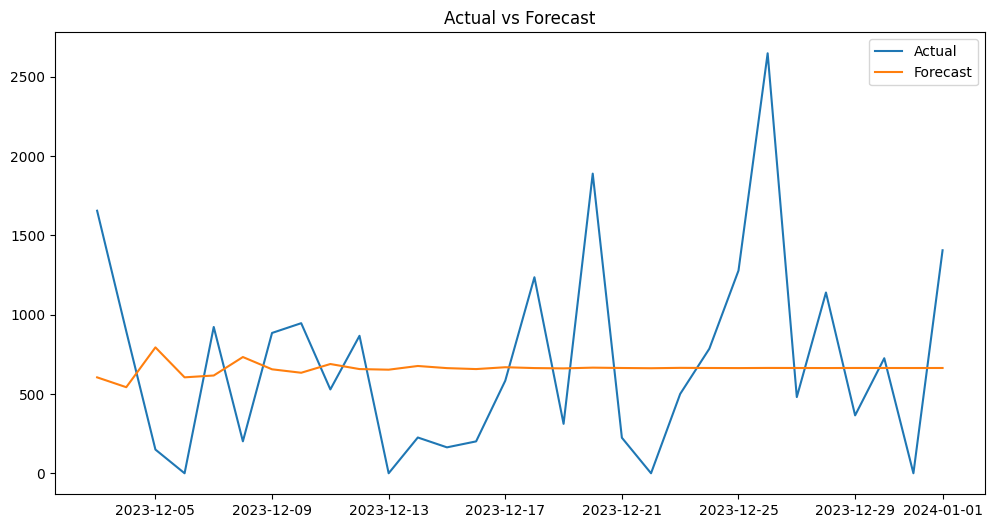

In [13]:
# -----------------------------
# 11. Plot Actual vs Forecast
# -----------------------------

plt.figure(figsize=(12,6))
plt.plot(test['Order Date'], test['Sales'], label="Actual")
plt.plot(test['Order Date'], forecast, label="Forecast")
plt.legend()
plt.title("Actual vs Forecast")
plt.show()

In [14]:
# -----------------------------
# 12. Forecast Next 30 Days
# -----------------------------

final_model = ARIMA(daily_sales['Sales'], order=(5,1,0))
final_model_fit = final_model.fit()

future_forecast = final_model_fit.forecast(steps=30)

future_dates = pd.date_range(
    start=daily_sales['Order Date'].max(),
    periods=30,
    freq='D'
)

future_df = pd.DataFrame({
    'Order Date': future_dates,
    'Forecasted Sales': future_forecast
})

print("\nFuture 30-Day Forecast:")
print(future_df.head())



Future 30-Day Forecast:
     Order Date  Forecasted Sales
1094 2024-01-01        662.026727
1095 2024-01-02        723.183862
1096 2024-01-03        640.376776
1097 2024-01-04        753.949593
1098 2024-01-05        591.339899


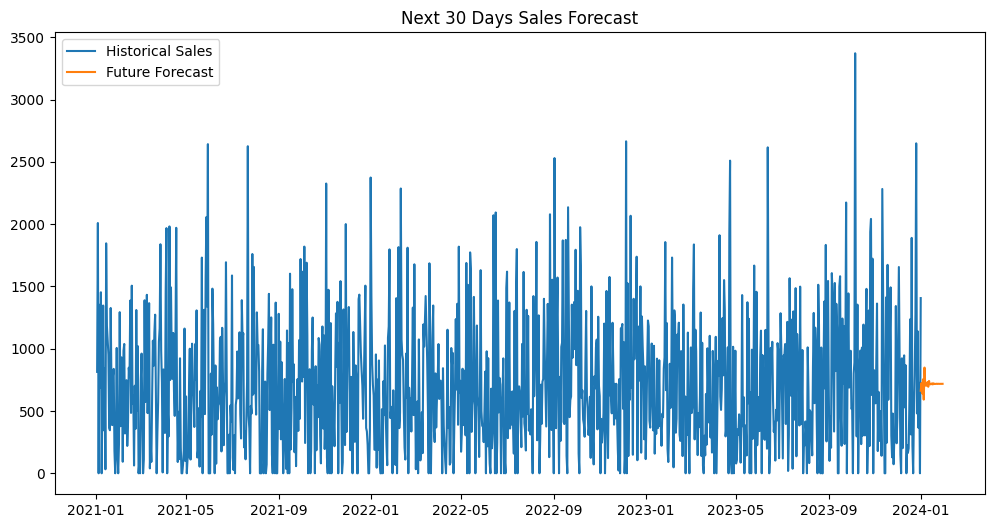

In [15]:
# -----------------------------
# 13. Final Forecast Plot
# -----------------------------

plt.figure(figsize=(12,6))
plt.plot(daily_sales['Order Date'], daily_sales['Sales'], label="Historical Sales")
plt.plot(future_df['Order Date'], future_df['Forecasted Sales'], label="Future Forecast")
plt.legend()
plt.title("Next 30 Days Sales Forecast")
plt.show()


In [16]:
# -----------------------------
# 14. Forecast Trend Detection
# -----------------------------

forecast_values = np.array(future_forecast)
trend_direction = np.polyfit(range(len(forecast_values)), forecast_values, 1)[0]

if trend_direction > 0:
    print("\nForecast Trend: Increasing")
elif trend_direction < 0:
    print("\nForecast Trend: Decreasing")
else:
    print("\nForecast Trend: Flat")

print("Average Forecasted Daily Sales:", round(forecast_values.mean(), 2))


# ==========================================
# End of Project
# ==========================================


Forecast Trend: Increasing
Average Forecasted Daily Sales: 713.89
